# Vecinos más cercanos (K-NN) y Balance Sesgo - Varianza

Proponemos explorar el balance entre sesgo y varianza construyendo modelos de diferente complejidad empleando la aproximación por vecinos más cercanos. Asimismo, exploraremos este balance en ejercicios complementarios basados en árboles de decisión para distintas profundidades. Primero, analizaremos el balance en modelos de regresión y luego con clasificadores.   

## Regresión por vecinos más cercanos

### Atributos numéricos

Vamos a definir y ajustar un modelo de regresión por vecinos más cercanos para la variable `body_mass_g` del conjunto de datos de pingüinos. En primer lugar, solamente consideraremos los atributos numéricos.

In [1]:
# Permite identificar donde estamos parados para
# luego escribir el PATH correcto para acceder al conjunto de datos
import os
print(os.getcwd())

/content


Al igual que en las guías anteriores, vamos a leer el conjunto de datos de pingüinos `penguins_size.csv`. Recordamos que contiene algunos `NA` que debemos eliminar... Y, además, hay una muestra con el atributo `sex` definido como "." que también borraremos...

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Lic_en_Datos/IAA/datos/penguins_size.csv')  #drive mica
#df = pd.read_csv('IAA_Guia_2_clasificacion_binaria.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [8]:
df = df.dropna()

In [9]:
# Confirmamos la distribución de muestras por especie
# Presenta un balance aceptable?
df['species'].value_counts()

,count
species,
Adelie,146
Gentoo,120
Chinstrap,68


Ahora, nos quedamos solamente con los atributos numéricos y separamos en datos de entrenamiento y prueba. Recordamos que nuestro *target* será `body_mass_g`

In [14]:
from sklearn.model_selection import train_test_split
# COMPLETAR
X = df[['culmen_length_mm','culmen_depth_mm']] # no puedo usar categoricas
y = df['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Vamos a generar una instancia de la clase `KNeighborsRegressor()` que nos permitirá realizar un ajuste por vecinos más cercanos. Asimismo, es fundamental reescalar los atributos para que las *distancias* en las diferentes direcciones sean comparables incorporando previamente una transformación de la clase `StandardScaler()`. Dado que siempre ambos procesos irán encadenados, es conveniente introducir un `Pipeline`.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# Definir pipeline: escalado + KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))  # podés ajustar k según convenga
])

# Ver parámetros disponibles
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsRegressor())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsRegressor(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Ahora, podemos operar con el *pipe* como si se tratara de un estimador regular. Es decir, podemos aplicar al *pipe* los métodos `.fit()`, `.predict()`, o cualquier otro, en el orden correspondiente. Particularmente, nos interesa estudiar el balance sesgo-varianza. En este caso, podemos definir un ciclo que itere sobre el número de primeros vecinos y almacenar los resultados de algunas métricas tanto en entrenamiento como en prueba. Por ejemplo, podemos tomar el método `.score()` que recupera el valor del coeficiente de determinación ($R^2$).

Para cada iteración, debemos modifcar el número de vecinos más cercanos. Como vimos, podemos acceder a esta configuración a través del método `.set_params()` y pasando como argumento `knn__n_neighbors=k`. En este caso, `k` representa el número de vecinos más cercanos y la variable o *key* se construye como "nombre_del_paso + doble guión bajo (__) + nombre del parámetro".  En este ejemplo elegimos como nombre del segundo paso del `Pipeline` `knn`.

Sugerimos para `k` valores en el rango entre 1 y 50.

In [18]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

k_all = np.arange(2,41, 2)
r2_train = np.array([])
r2_test = np.array([])
rmse_train  = np.array([])
rmse_test = np.array([])
for k in k_all:
    pipe.set_params(knn__n_neighbors=k)
    pipe.fit(X_train, y_train)
    r2_train = np.append(r2_train, [pipe.score(X_train, y_train)])
    r2_test = np.append(r2_test, [pipe.score(X_test, y_test)])
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    rmse_train = np.append(rmse_train, np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse_test = np.append(rmse_test, np.sqrt(mean_squared_error(y_test, y_test_pred)))

En este ejemplo, contamos con los $R^2$ de entrenamiento y prueba en función del número de vecinos. Así, podemos trazar ambas curvas que usualmente se representan en función de 1/k.

**Ejercicio**: almacenar simultaneamente los RMSE de entrenamiento y prueba en función del número de vecinos. Realizar el gráfcio correspondiente.

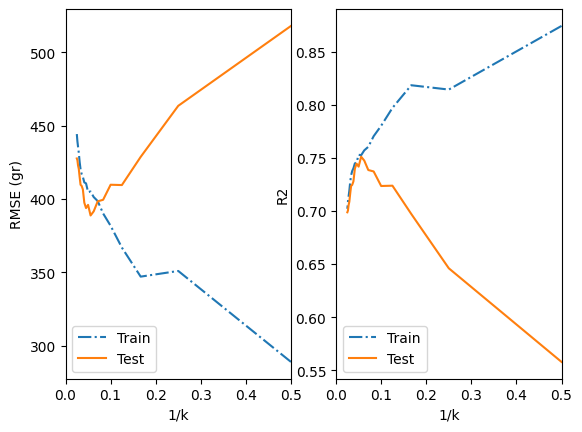

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1,ncols = 2, dpi=100)
ax[0].plot(1/k_all, rmse_train, label='Train', linestyle='-.')
ax[0].plot(1/k_all, rmse_test, label='Test', linestyle='-')
ax[0].set_xlim([0,np.max(1/k_all)])
ax[0].set_xlabel("1/k")
ax[0].set_ylabel("RMSE (gr)")
ax[0].legend(loc='lower left')

ax[1].plot(1/k_all, r2_train, label='Train', linestyle='-.')
ax[1].plot(1/k_all, r2_test, label='Test', linestyle='-')
ax[1].set_xlim([0,np.max(1/k_all)])
ax[1].set_xlabel("1/k")
ax[1].set_ylabel("R2")
ax[1].legend(loc='lower left')

**Ejericio**: Señalar en las figuras anteriores las zonas de sobreajuste (over-fitting) y subajuste (under-fitting). Explicar cómo se las encuentra. ¿Cuál podría ser un rango de `k` óptimo?

**Sobreajuste (over-fitting) ocurre cuando:**

* El error en Train es muy bajo.
Pero el error en Test empieza a subir mucho (o R² en Test baja fuerte).

* En tu gráfico:

  * Eso pasa cuando 1/k es alto, es decir cuando k es muy chico (pocos vecinos), tipo desde 1/k ≈ 0.15 hacia la derecha.Ves que el RMSE en Train es muy bajo, pero el de Test empieza a subir.
 * Y en R², el de Train se mantiene alto, pero el de Test baja.

 **¿Dónde está el underfitting?**
Subajuste (under-fitting) ocurre cuando:

* Ambos errores (Train y Test) son altos.
* Y los scores R² son bajos.

* En tu gráfico:

 * Esto sucede cuando 1/k es muy bajo (o sea cuando k es muy alto, tipo 1/k < 0.05). Ahí ves que:

  * RMSE Train y Test son altos.

  * Y R² de ambos son bajos.

 **¿Cuál sería un rango óptimo de k?**

Idealmente donde:
* RMSE Test es bajo.

* R² Test es relativamente alto.Y no hay una gran diferencia entre Train y Test.

* Según tu gráfico:Esto ocurre más o menos entre 1/k ≈ 0.07 y 1/k ≈ 0.15
(lo cual corresponde a k ≈ 7 a 14 vecinos) . Ahí:

 * RMSE Test es bajo.

 * R² Test es alto.La brecha entre Train y Test no es tan grande.

### Atributos numéricos y categóricos

Proponemos repetir el estudio del balance sesgo-varianza pero ahora también incluyendo las variables categóricas `species` y `sex` en el análisis. Separamos en datos de entrenamiento y prueba recordando que nuestro *target* será `body_mass_g`. Asimismo, construimos listas con los nombres de los atriutos numéricos y categóricos que serán usadas más adelante

In [20]:
pgs_numeric = df.select_dtypes(include='number').columns.to_list()
pgs_numeric.remove('body_mass_g')
pgs_cat = ['species', 'sex']
pgs_drop = ['island']
print(pgs_numeric)

X = df[pgs_numeric + pgs_cat]
y = df['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']


Notamos que las variables numéricas y categóricas no pueden tratarse de la misma manera. Por un lado, continuaremos reescalando los datos cuantitativos usando la clase `StandardScaler()`. Por otro lado, codificaremos los datos cualitativos aplicando una transformación por `OneHotEncoder()`. Ambas operaciones se pueden incluir en un mismo preprcesamiento con la ayuda de `ColumnTransformer`. Finalmente, este preprocesamiento se encadena con la regresión por vecinos más cercanos mediante `Pipeline`. El objetivo es que los datos sean transformados, según su tipo, antes de llegar al regresor.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preproc = ColumnTransformer(
    [('scaler', StandardScaler(), pgs_numeric),
     ('one-hot',OneHotEncoder(), pgs_cat),
     ('drop', 'drop', pgs_drop),
    ])

pipe = Pipeline([('preproc', preproc), ('knn', KNeighborsRegressor())])
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm']),
                                                 ('one-hot', OneHotEncoder(),
                                                  ['species', 'sex']),
                                                 ('drop', 'drop',
                                                  ['island'])])),
                ('knn', KNeighborsRegressor())])

De manera análoga, buscamos realizar gráficos para las distintas métricas consideradas, tanto con datos de entrenamiento como de prueba. Para ello, nos planteamos un ciclo que itera sobre un número creciente de primeros vecinos (en el rango entre 1 y 50).

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


In [27]:
# COMPLETAR
# Realizar un ciclo sobre el número de vecinos K, almacenar las respectivas métricas
k_all = range(1, 51)
rmse_train = []
rmse_test = []

# Preprocesador para numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, pgs_numeric),
        ('cat', categorical_transformer, pgs_cat)
    ])

# Iterar sobre k
for k in k_all:
    # Definir pipeline para cada k
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=k))
    ])

    # Ajustar modelo
    model.fit(X_train, y_train)

    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular RMSE
    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

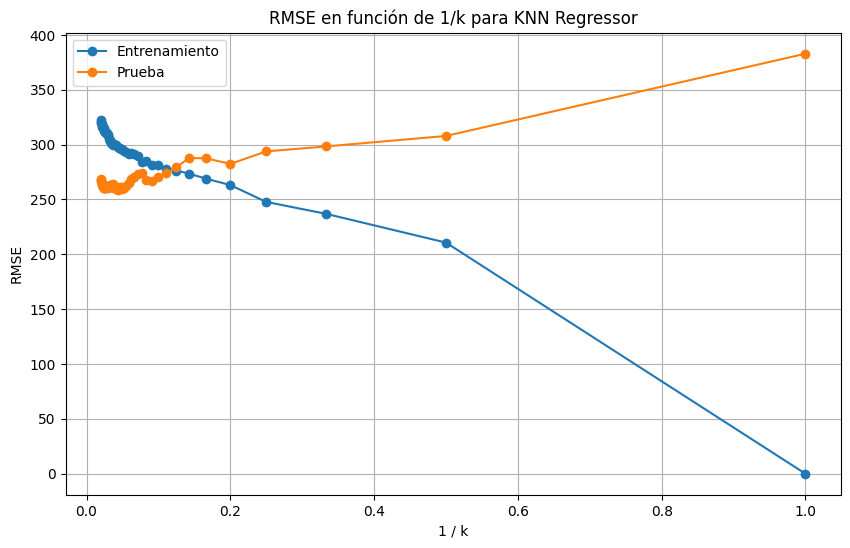

In [28]:
# COMPLETAR
# Elaborar una figura que trace los RMSE de prueba y entrenamiento en función de 1/k

plt.figure(figsize=(10, 6))

plt.plot(1/np.array(k_all), rmse_train, label='Entrenamiento', marker='o')
plt.plot(1/np.array(k_all), rmse_test, label='Prueba', marker='o')

plt.xlabel('1 / k')
plt.ylabel('RMSE')
plt.title('RMSE en función de 1/k para KNN Regressor')
plt.legend()
plt.grid(True)
plt.show()



**Ejercicio**: Identificar regiones de sobre y subajuste. ¿Se podría afirmar que el modelo que toma variables numéricas y categóricas tiene un mejor desempeño que el que solo emplea datos numéricos? Repetir el análisis usando `DecisionTreeRegressor` en función de diferentes profundidades.

## Clasificación por vecinos más cercanos

Vamos a definir y ajustar un modelo de clasificación por vecinos más cercanos para la variable `species` del conjunto de datos de pingüinos. En este caso consideraremos solamente el atributos numérico `flipper_length_mm` y, adicionalmente, la variable categórica `sex`. Deberemos:

1. Separa en datos de entrenamiento y prueba.
2. Elaborar una transformación por columnas que aplique la clase `StandardScaler` a los datos numéricos y la clase `OneHotEncoder` a los cateóricos.
3. Elaborar un pipeline que encadene el preprocesado por columnas y, luego, inicie el proceso de `KNeighborsClassifier()`.


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [29]:
pgs_numeric = ['flipper_length_mm']
pgs_cat = ['sex']

print(pgs_numeric)

['flipper_length_mm']


In [31]:
from sklearn.neighbors import KNeighborsClassifier

# COMPLETAR
# Definir X e y
X = df[pgs_numeric + pgs_cat]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir un preprocesado pór columnas que aplique
# StandardScaler() en la variable numérica
# OneHotEncoder() en la variable categórica

# Definir preprocesador por columnas
preproc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), pgs_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), pgs_cat)
    ])

# Definir pipeline con preprocesador y clasificador
pipe = Pipeline(steps=[
    ('preprocessor', preproc),
    ('classifier', KNeighborsClassifier())
])

# Mostrar los parámetros del pipeline
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['flipper_length_mm']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['sex'])])),
  ('classifier', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['flipper_length_mm']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['sex'])]),
 'classifier': KNeighborsClassifier(),
 'preprocessor__force_int_remainder_cols': True,
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'drop',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor__transformers': [('num',
   StandardScaler(),
   ['flipper_length_mm']),
  ('cat', OneHotEncoder(han

In [33]:
X_train.head()

,flipper_length_mm,sex
292,221.0,MALE
302,212.0,FEMALE
62,185.0,FEMALE
181,205.0,MALE
15,185.0,FEMALE


El análisis del balance sesgo-varianza para los clasificadores conduce, al igual que antes, a la puesta en práctica de un ciclo que recorre valores crecientes de `k` para vecinos más cercanos y, calcula y almacena la exactitud (`accuracy_score`). Dado que las tres especies de pingüinos se presentan en cantidades iguales, la exactitud es una métrica adecuada para evaluar el desempeño general de los clasificadores. Debemos recordar que otras métricas, como el recall o precision deberían calcularse por especie ya que operamos con tres clases diferentes.  

In [32]:

from sklearn.metrics import accuracy_score

# COMPLETAR
# Realizar un ciclo sobre el número de vecinos K, almacenar la respectiva métrica
k_all = range(1, 30)
acc_train = []
acc_test = []

for k in k_all:
    # Definir pipeline con k actual
    pipe = Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

    # Ajustar modelo
    pipe.fit(X_train, y_train)

    # Predecir sobre train y test
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Calcular exactitud
    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_test, y_test_pred))

Los valores registrados de exactitud en función del número de primeros vecinos, tanto para los conjuntos de pureba como entrenamiento nos habilitan el trazado de una figura que representa el balance sesgo-varianza.

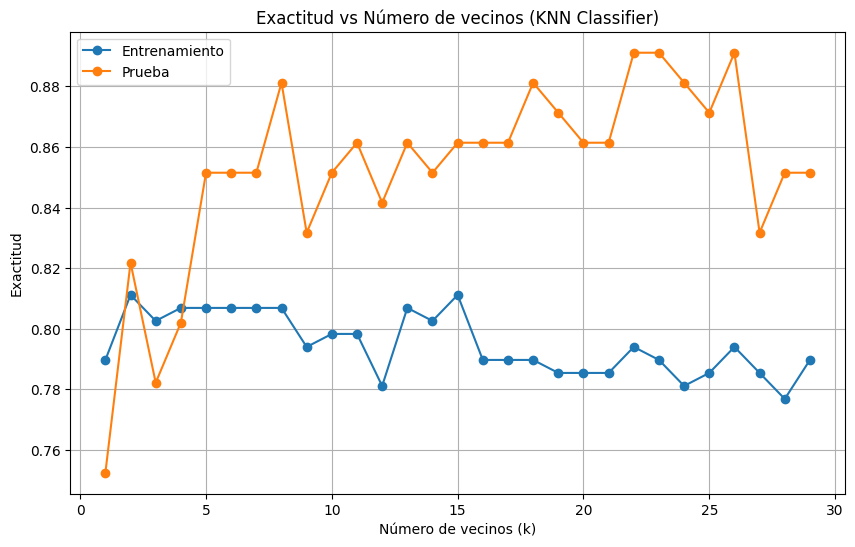

In [34]:
# COMPLETAR
# Elaborar una figura que trace los Accuracy de prueba y entrenamiento en función de 1/k
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(k_all, acc_train, label='Entrenamiento', marker='o')
plt.plot(k_all, acc_test, label='Prueba', marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Exactitud')
plt.title('Exactitud vs Número de vecinos (KNN Classifier)')
plt.legend()
plt.grid(True)
plt.show()



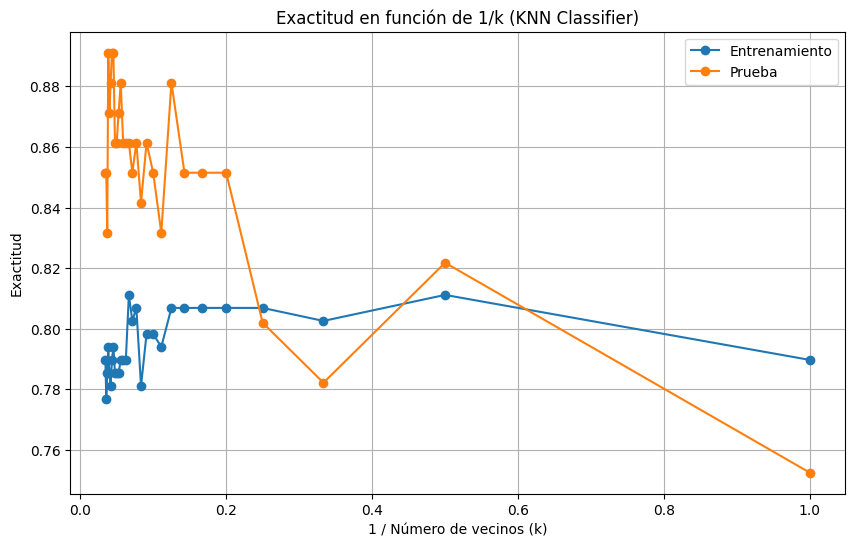

In [35]:
import matplotlib.pyplot as plt

# Calcular 1/k para el eje x
inv_k = [1/k for k in k_all]

# Crear figura
plt.figure(figsize=(10,6))

# Graficar accuracy en entrenamiento y prueba
plt.plot(inv_k, acc_train, label='Entrenamiento', marker='o')
plt.plot(inv_k, acc_test, label='Prueba', marker='o')

# Etiquetas y título
plt.xlabel('1 / Número de vecinos (k)')
plt.ylabel('Exactitud')
plt.title('Exactitud en función de 1/k (KNN Classifier)')
plt.legend()
plt.grid(True)
plt.show()

**Pregunta**: Sabiendo que el atributo `sex` es binario, ¿podríamos pasar como argumento de `OneHotEncoder` la opción `drop='first'`? ¿Tiene impacto en el resultado?

**Ejercicio**: Reconocer zonas de sobre y subajuste. Elegir un `k`, número de primeros vecinos, que considere ofrezca el mejor balance sesgo-varianza. Volver a ajustar el modelo para dicho `k` e imprimir las predicciones para el conjunto de prueba. Notar que la predicción es el nombre de la especie correspondiente a cada muestra o dato.

In [37]:
# Elegir el K que alcanza mejor balance sesgo-varianza (según gráfico)
k = 7

# Definir nuevamente el pipeline con ese K
pipe = Pipeline(steps=[
    ('preprocessor', preproc),
    ('classifier', KNeighborsClassifier(n_neighbors=k))
])

# Ajustar modelo con datos de entrenamiento
pipe.fit(X_train, y_train)

# Predecir sobre datos de prueba
y_pred_test = pipe.predict(X_test)

# Mostrar las predicciones
print(y_pred_test)

['Adelie' 'Gentoo' 'Adelie' 'Chinstrap' 'Adelie' 'Gentoo' 'Gentoo'
 'Adelie' 'Adelie' 'Chinstrap' 'Adelie' 'Chinstrap' 'Chinstrap' 'Adelie'
 'Gentoo' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Adelie' 'Adelie'
 'Gentoo' 'Chinstrap' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie'
 'Gentoo' 'Adelie' 'Gentoo' 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo'
 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Chinstrap'
 'Chinstrap' 'Adelie' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo'
 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo' 'Adelie' 'Adelie'
 'Adelie' 'Chinstrap' 'Gentoo' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie'
 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo'
 'Gentoo' 'Gentoo' 'Chinstrap' 'Adelie' 'Adelie' 'Adelie' 'Gentoo'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo'
 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Chinstrap' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Chinstrap' 'Adelie' 'Adelie' 'Adelie']


**Ejercicio**: Calcular la matriz de confusión para `k` cuando toma el valor que se considera realiza el mejor balance entre sesgo y varianza. Identificar que especies confunde el clasificador en mayor cantidad.

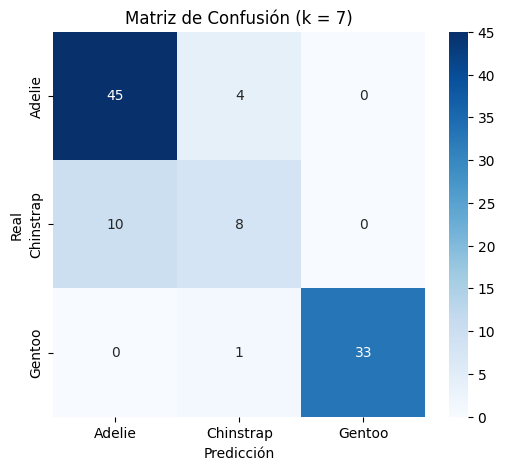

In [38]:
# COMPLETAR
# Imprimir la matriz de confusión para los datos de prueba con el k óptimo
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, labels=pipe.classes_)

# Mostrar la matriz como heatmap para mejor visualización
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipe.classes_,
            yticklabels=pipe.classes_)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (k = {k})')
plt.show()


**Ejercicio**: Representar en una figura las especies que serían predecidas cuando `flipper_length_mm`varía en el rango entre 160 y 240, para ambos sexos. Superponer con lospuntos de entrenamiento. Observar como cambia la figura con la elección del número de vecinos más cercanos.

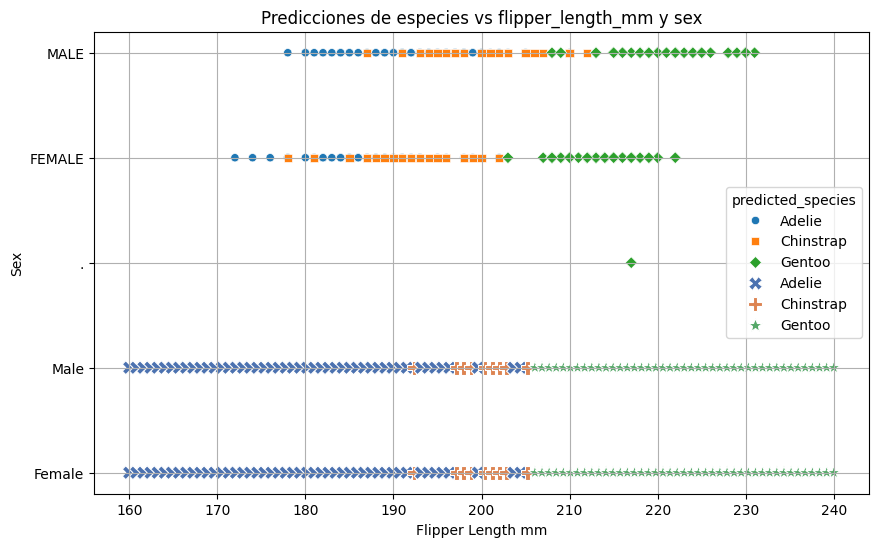

In [39]:
# COMPLETAR
# Realizar la representación de especies en función de
# los atributos flipper_length_mm y sex

# Armar un DataFrame que recorra los valores
# de flipper_length_mm desde el mínimo hasta el máximo
# y el atributo sex en sus valores Male y FEMALE

# Predecir las especies

# Considerar los métodos de seaborn
# catplot, stripplot o scatterplot para la representación
# de las especies en función del atributo

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rango de flipper_length_mm y valores de sex
flipper_range = np.linspace(160, 240, 100)  # Genera 100 valores entre 160 y 240
sex_values = ['Male', 'Female']

# Crear DataFrame con todas las combinaciones posibles de flipper_length_mm y sex
grid = pd.DataFrame([(flipper, sex) for flipper in flipper_range for sex in sex_values], columns=['flipper_length_mm', 'sex'])

# Realizar las predicciones para las combinaciones creadas
species_pred = pipe.predict(grid)

# Añadir las predicciones al DataFrame
grid['predicted_species'] = species_pred

# Visualizar las predicciones junto con los datos de entrenamiento
plt.figure(figsize=(10,6))

# Gráfico de las predicciones (superpuestas con los puntos de entrenamiento)
sns.scatterplot(data=df, x='flipper_length_mm', y='sex', hue='species', style='species', markers=["o", "s", "D"], legend='full')

# Añadir predicciones del grid
sns.scatterplot(data=grid, x='flipper_length_mm', y='sex', hue='predicted_species', style='predicted_species', markers=["X", "P", "*"], s=100, legend='full', palette="deep")

# Añadir detalles
plt.title('Predicciones de especies vs flipper_length_mm y sex')
plt.xlabel('Flipper Length mm')
plt.ylabel('Sex')
plt.grid(True)
plt.show()


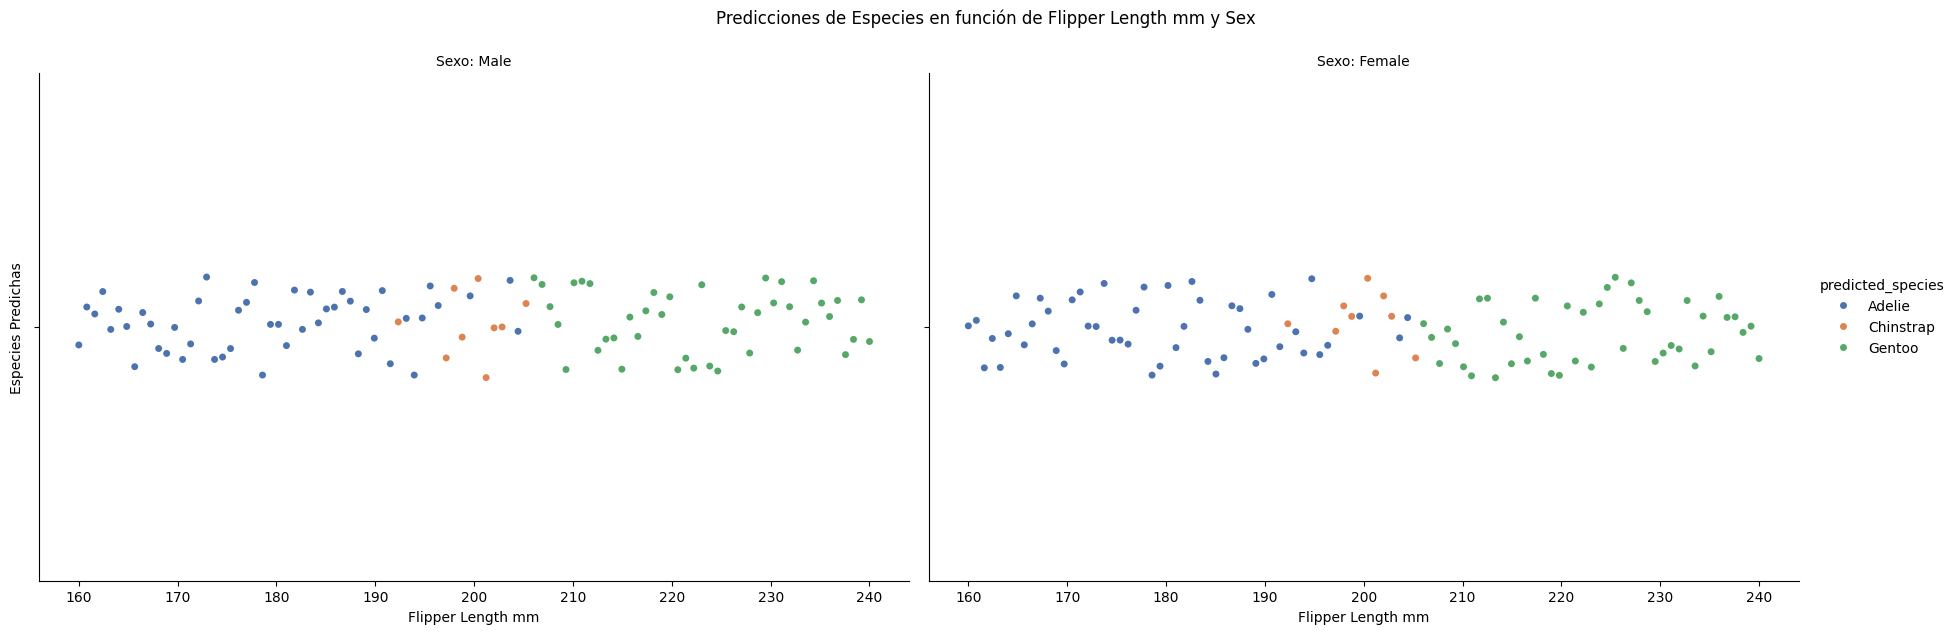

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico de tipo catplot
g = sns.catplot(
    data=grid,
    x='flipper_length_mm',
    hue='predicted_species',
    col='sex',  # Para ver el resultado por separado para Male y Female
    kind='strip',  # El tipo de gráfico (puedes cambiarlo a 'swarm' o 'box' si lo prefieres)
    palette="deep",  # Colores para las especies
    height=6,  # Tamaño del gráfico
    aspect=1.5  # Aspecto (relación entre largo y alto del gráfico)
)

# Añadir títulos y etiquetas
g.set_axis_labels('Flipper Length mm', 'Especies Predichas')
g.set_titles("Sexo: {col_name}")
plt.suptitle('Predicciones de Especies en función de Flipper Length mm y Sex', y=1.05)
plt.show()


<ipython-input-41-c4667a879471>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Especies Predichas', loc='upper left')


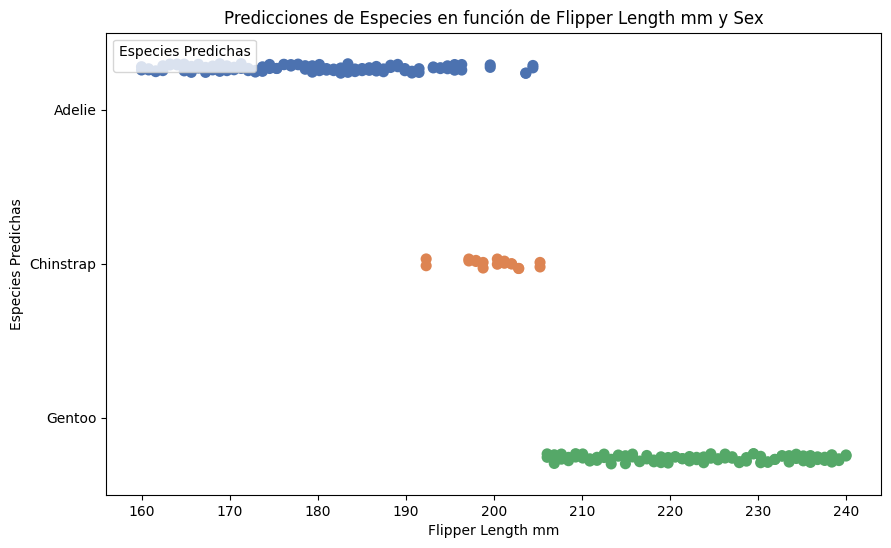

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico con stripplot
plt.figure(figsize=(10,6))

sns.stripplot(
    data=grid,
    x='flipper_length_mm',  # Eje X será flipper_length_mm
    y='predicted_species',  # Eje Y serán las especies predichas
    hue='predicted_species',  # Diferenciar por especie con colores
    dodge=True,  # Separar los puntos para cada especie
    jitter=True,  # Aleatorizar los puntos para evitar superposiciones
    palette="deep",  # Colores para las especies
    size=8,  # Tamaño de los puntos
    marker='o'  # Forma de los puntos
)

# Añadir título y etiquetas
plt.title('Predicciones de Especies en función de Flipper Length mm y Sex')
plt.xlabel('Flipper Length mm')
plt.ylabel('Especies Predichas')
plt.legend(title='Especies Predichas', loc='upper left')

plt.show()

**Ejercicio**: Explorar cómo afecta la clasificación si los *targets* se pesan por la inversa de la distancia al punto.

**Ejercicio**: Repetir el análisis usando `DecisionTreeClassifier` en función de diferentes profundidades.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dividir los datos en entrenamiento y prueba
X = df[['flipper_length_mm', 'sex']]  # Ejemplo de columnas
y = df['species']

# Codificar la variable categórica 'sex'
X = pd.get_dummies(X, columns=['sex'], drop_first=True)

# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar KNN con 'distance' como peso
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Ajustar el modelo
knn.fit(X_train, y_train)

# Realizar las predicciones
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Evaluar el desempeño (Accuracy)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy en entrenamiento (weights="distance"): {acc_train:.4f}')
print(f'Accuracy en prueba (weights="distance"): {acc_test:.4f}')


Accuracy en entrenamiento (weights="distance"): 0.8283
Accuracy en prueba (weights="distance"): 0.8218


In [43]:
# Inicializar KNN con 'uniform' como peso
knn_uniform = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# Ajustar el modelo
knn_uniform.fit(X_train, y_train)

# Realizar las predicciones
y_pred_train_uniform = knn_uniform.predict(X_train)
y_pred_test_uniform = knn_uniform.predict(X_test)

# Evaluar el desempeño (Accuracy)
acc_train_uniform = accuracy_score(y_train, y_pred_train_uniform)
acc_test_uniform = accuracy_score(y_test, y_pred_test_uniform)

print(f'Accuracy en entrenamiento (weights="uniform"): {acc_train_uniform:.4f}')
print(f'Accuracy en prueba (weights="uniform"): {acc_test_uniform:.4f}')


Accuracy en entrenamiento (weights="uniform"): 0.8112
Accuracy en prueba (weights="uniform"): 0.8119


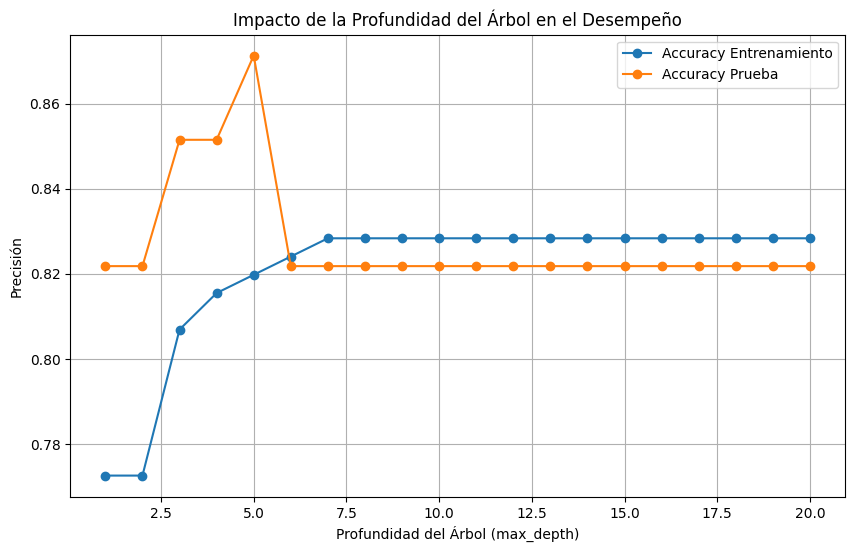

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Dividir los datos en entrenamiento y prueba
X = df[['flipper_length_mm', 'sex']]  # Atributos de ejemplo
y = df['species']

# Codificar la variable categórica 'sex'
X = pd.get_dummies(X, columns=['sex'], drop_first=True)

# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Listas para almacenar los resultados
depth_range = range(1, 21)  # Probar diferentes profundidades entre 1 y 20
acc_train = []
acc_test = []

# Realizar un ciclo sobre las diferentes profundidades
for depth in depth_range:
    # Inicializar el clasificador con una profundidad máxima
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)

    # Ajustar el modelo con los datos de entrenamiento
    tree.fit(X_train, y_train)

    # Realizar predicciones en los conjuntos de entrenamiento y prueba
    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)

    # Calcular las métricas de precisión (accuracy)
    acc_train.append(accuracy_score(y_train, y_pred_train))
    acc_test.append(accuracy_score(y_test, y_pred_test))

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(depth_range, acc_train, label='Accuracy Entrenamiento', marker='o')
plt.plot(depth_range, acc_test, label='Accuracy Prueba', marker='o')
plt.xlabel('Profundidad del Árbol (max_depth)')
plt.ylabel('Precisión')
plt.title('Impacto de la Profundidad del Árbol en el Desempeño')
plt.legend()
plt.grid(True)
plt.show()
